In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
# from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import seaborn as sns
sns.set_theme(style="darkgrid")

#imports for regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import RepeatedKFold
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV 

randomState = 6164880

C:\Users\thijs\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


Import data, and remove oddities such as , and . being switched, letter where numbers where expected, and convert everything to the right datatype

In [2]:
data=pd.read_csv("data.tab", sep='\t', header=None, names = ["id", "runday", "country", "date", "new_deaths_smoothed_per_million", "stringency_index", "median_age", "gdp_per_capita", "tour_inc_gdp", "civilliberties", "trustp", "icu_bed", "lr", "plurality", "oppfrac", "govfrac", "checks"])



for col in data.columns.drop(['country', 'date']):
    data[col] = data[col].astype("string").str.replace(',','.').str.replace(r'[^0-9_._e_-]+', '')
    # for value in col:
        # if value.astype("string") =
    # dfObject['C'] = dfObject['C'].str.replace(r'[^0-9]+', '')
data = data.replace('', np.NaN)



#leave the string columns, then convert cols to int or float as needed.
for col in data.columns.drop(['country', 'date']):
    # display(col)
    if col in ['id', 'runday', 'civilliberties', 'plurality', 'checks']:
        data[col] = data[col].astype("int")
    else:
        data[col] = data[col].astype("float")
     # data[col] = data[col].astype("float")
data['country'] = data['country'].astype('string')


data = data.drop(['lr'], axis = 1)#lr is empty for Switzerland, so we drop it


data = data.sort_values(["id","runday"], axis = 0, ascending = True)
# display(data.head(10))



C:\Users\thijs\AppData\Local\Temp\ipykernel_18108\4055093126.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  data[col] = data[col].astype("string").str.replace(',','.').str.replace(r'[^0-9_._e_-]+', '')


,id,runday,country,date,new_deaths_smoothed_per_million,stringency_index,median_age,gdp_per_capita,tour_inc_gdp,civilliberties,trustp,icu_bed,plurality,oppfrac,govfrac,checks
395,1,56,Austria,25-2-2020,NaN,11.11,44.4,45436.688,4.4,56,0.07892,1.541315,0,0.630643,0.396478,5
412,1,57,Austria,26-2-2020,NaN,11.11,44.4,45436.688,4.4,56,0.07892,1.541315,0,0.630643,0.396478,5
429,1,58,Austria,27-2-2020,NaN,11.11,44.4,45436.688,4.4,56,0.07892,1.541315,0,0.630643,0.396478,5
446,1,59,Austria,28-2-2020,NaN,11.11,44.4,45436.688,4.4,56,0.07892,1.541315,0,0.630643,0.396478,5
463,1,60,Austria,29-2-2020,NaN,11.11,44.4,45436.688,4.4,56,0.07892,1.541315,0,0.630643,0.396478,5
2,1,61,Austria,1-3-2020,0.0,11.11,44.4,45436.688,4.4,56,0.07892,1.541315,0,0.630643,0.396478,5
19,1,62,Austria,2-3-2020,0.0,11.11,44.4,45436.688,4.4,56,0.07892,1.541315,0,0.630643,0.396478,5
36,1,63,Austria,3-3-2020,0.0,11.11,44.4,45436.688,4.4,56,0.07892,1.541315,0,0.630643,0.396478,5
53,1,64,Austria,4-3-2020,0.0,11.11,44.4,45436.688,4.4,56,0.07892,1.541315,0,0.630643,0.396478,5
70,1,65,Austria,5-3-2020,0.0,11.11,44.4,45436.688,4.4,56,0.07892,1.541315,0,0.630643,0.396478,5


In [3]:
# NaNs = pd.DataFrame()
# for country in np.unique(data["country"]):
#     # print(country)
#     countryData = data.loc[data['country'] == country]
    
#     # print(country, " has ", countryData.isna().sum(), " \n NaN values \n")

# data = data.columns.drop(['lr'])#lr is empty for Switzerland
data.shape

(13790, 16)

In [4]:
print(data.isna().sum()) #NaNs before

for col in data.columns:
    # display(data[col].dtype)
    if col in ['country','date', 'plurality', 'lr']: #would prefer to select on datatype, but those are a bit strange so I'll leave it hardcoded like this
        data[col] = data[col].interpolate('ffill') #interpolate non-numeric cols with forward fill
    else:
        data[col] = data[col].interpolate('linear') #interpolate numeric cols with linear interpolation
        
#the first 5 days of austria here here are empty, so linear interpolation doesnt work, therefore we interpolate this col again with backfill, since the deaths are 0 for a while anyway we can pretty safely assume this is correct
data['new_deaths_smoothed_per_million'] = data['new_deaths_smoothed_per_million'].interpolate('bfill')#the first 5 days of austria here here are empty, so linear interpolation doesnt work, therefore we interpolate this col again with backfill, since the deaths are 0 for a while anyway we can pretty safely assume this is correct



print(data.isna().sum()) #NaNs after


id                                   0
runday                               0
country                              0
date                                 0
new_deaths_smoothed_per_million    259
stringency_index                   197
median_age                           0
gdp_per_capita                       0
tour_inc_gdp                         0
civilliberties                       0
trustp                               0
icu_bed                              0
plurality                            0
oppfrac                              0
govfrac                              0
checks                               0
dtype: int64
id                                 0
runday                             0
country                            0
date                               0
new_deaths_smoothed_per_million    0
stringency_index                   0
median_age                         0
gdp_per_capita                     0
tour_inc_gdp                       0
civilliberties                

In [5]:
data.describe()
data.head()

,id,runday,country,date,new_deaths_smoothed_per_million,stringency_index,median_age,gdp_per_capita,tour_inc_gdp,civilliberties,trustp,icu_bed,plurality,oppfrac,govfrac,checks
395,1,56,Austria,25-2-2020,0.0,11.11,44.4,45436.688,4.4,56,0.07892,1.541315,0,0.630643,0.396478,5
412,1,57,Austria,26-2-2020,0.0,11.11,44.4,45436.688,4.4,56,0.07892,1.541315,0,0.630643,0.396478,5
429,1,58,Austria,27-2-2020,0.0,11.11,44.4,45436.688,4.4,56,0.07892,1.541315,0,0.630643,0.396478,5
446,1,59,Austria,28-2-2020,0.0,11.11,44.4,45436.688,4.4,56,0.07892,1.541315,0,0.630643,0.396478,5
463,1,60,Austria,29-2-2020,0.0,11.11,44.4,45436.688,4.4,56,0.07892,1.541315,0,0.630643,0.396478,5


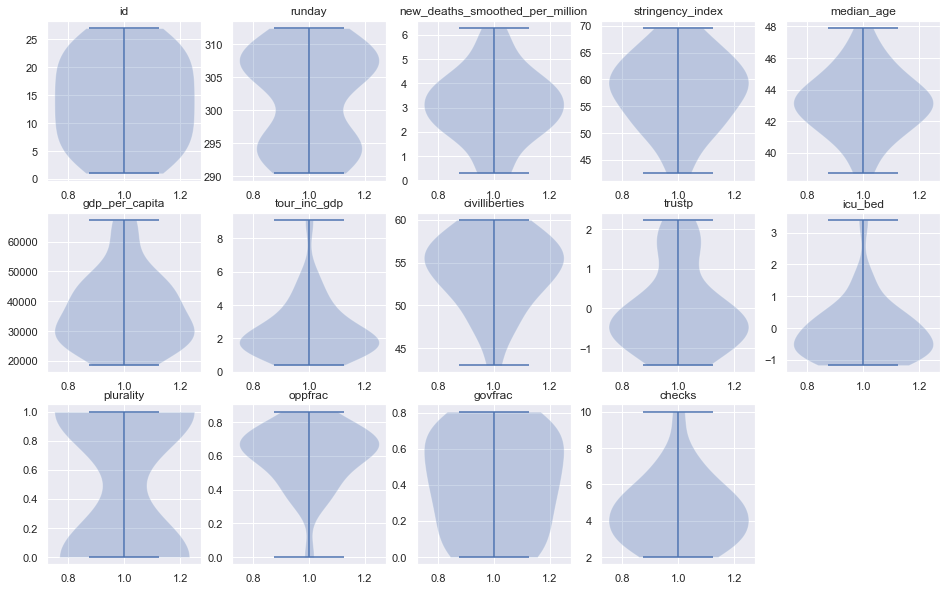

In [6]:
data_grouped = data.groupby("country")#.drop(['lr', 'plurality'], axis=1)
# display(data_grouped.mean())

plt.figure(figsize = (16,10))

for i,col in enumerate(data_grouped.mean(), 1):
    plt.subplot(3,5,i)
    plt.title(col)
    plt.violinplot(data_grouped.mean()[col])
    
plt.savefig('figures/violin.jpg', bbox_inches='tight')

In [7]:
countryData = data[data['country'] == "Belgium"]


# countryData.head()


countryData = countryData.drop(['country','date', 'plurality'],axis=1).dropna()
countryData.head()
# sns.lineplot(x="runday", y="new_deaths_smoothed_per_million", data=data)





,id,runday,new_deaths_smoothed_per_million,stringency_index,median_age,gdp_per_capita,tour_inc_gdp,civilliberties,trustp,icu_bed,oppfrac,govfrac,checks
554,2,35,0.185,11.11,41.8,42658.574,1.4,57,0.07892,0.63192,0.861873,0.682788,7
572,2,36,0.148,11.11,41.8,42658.574,1.4,57,0.07892,0.63192,0.861873,0.682788,7
590,2,37,0.111,11.11,41.8,42658.574,1.4,57,0.07892,0.63192,0.861873,0.682788,7
608,2,38,0.074,11.11,41.8,42658.574,1.4,57,0.07892,0.63192,0.861873,0.682788,7
626,2,39,0.037,11.11,41.8,42658.574,1.4,57,0.07892,0.63192,0.861873,0.682788,7


In [8]:
display(countryData.dtypes)
countryData.isnull().values.any()

id                                   int32
runday                               int32
new_deaths_smoothed_per_million    float64
stringency_index                   float64
median_age                         float64
gdp_per_capita                     float64
tour_inc_gdp                       float64
civilliberties                       int32
trustp                             float64
icu_bed                            float64
oppfrac                            float64
govfrac                            float64
checks                               int32
dtype: object

False

In [9]:
def absolute_maximum_scale(x):
    # return series / series.abs().max()
    if x.max() == 0:
        x_norm = x
    else:
        x_norm = x / x.max(axis=0)
    return x_norm

def normalise_z_score(x):
    # return series / series.abs().max()
    if np.std(x) == 0:
        x_norm = x - np.mean(x)
    else:
        x_norm = (x - np.mean(x)) / np.std(x)
    return x_norm

countryData_normalised = pd.DataFrame()
for col in countryData.columns:
    countryData_normalised[col] = normalise_z_score(countryData[col])

# countryData_normalised = pd.DataFrame(preprocessing.normalize(countryData, axis=0),columns=names)


# countryData_normalised.dropna().isnull().values.any()
display(countryData_normalised.head(), countryData.describe(), countryData_normalised.describe())

,id,runday,new_deaths_smoothed_per_million,stringency_index,median_age,gdp_per_capita,tour_inc_gdp,civilliberties,trustp,icu_bed,oppfrac,govfrac,checks
554,0.0,-1.728742,-0.710490,-2.81982,1.0,1.0,-1.0,0.0,-1.0,-1.0,-1.0,1.0,0.0
572,0.0,-1.722119,-0.717107,-2.81982,1.0,1.0,-1.0,0.0,-1.0,-1.0,-1.0,1.0,0.0
590,0.0,-1.715495,-0.723725,-2.81982,1.0,1.0,-1.0,0.0,-1.0,-1.0,-1.0,1.0,0.0
608,0.0,-1.708872,-0.730342,-2.81982,1.0,1.0,-1.0,0.0,-1.0,-1.0,-1.0,1.0,0.0
626,0.0,-1.702248,-0.736960,-2.81982,1.0,1.0,-1.0,0.0,-1.0,-1.0,-1.0,1.0,0.0


,id,runday,new_deaths_smoothed_per_million,stringency_index,median_age,gdp_per_capita,tour_inc_gdp,civilliberties,trustp,icu_bed,oppfrac,govfrac,checks
count,523.0,523.000000,523.000000,523.000000,5.230000e+02,5.230000e+02,5.230000e+02,523.0,5.230000e+02,5.230000e+02,5.230000e+02,5.230000e+02,523.0
mean,2.0,296.000000,4.157551,57.174302,4.180000e+01,4.265857e+04,1.400000e+00,57.0,7.891954e-02,6.319202e-01,8.618726e-01,6.827881e-01,7.0
std,0.0,151.121364,5.596636,16.351539,4.053971e-13,1.019609e-10,1.711380e-14,0.0,5.695340e-16,3.556115e-15,1.055722e-14,1.778058e-15,0.0
min,2.0,35.000000,-1.245000,11.110000,4.180000e+01,4.265857e+04,1.400000e+00,57.0,7.891954e-02,6.319202e-01,8.618726e-01,6.827881e-01,7.0
25%,2.0,165.500000,0.419000,50.930000,4.180000e+01,4.265857e+04,1.400000e+00,57.0,7.891954e-02,6.319202e-01,8.618726e-01,6.827881e-01,7.0
50%,2.0,296.000000,2.293000,60.190000,4.180000e+01,4.265857e+04,1.400000e+00,57.0,7.891954e-02,6.319202e-01,8.618726e-01,6.827881e-01,7.0
75%,2.0,426.500000,4.493000,63.890000,4.180000e+01,4.265857e+04,1.400000e+00,57.0,7.891954e-02,6.319202e-01,8.618726e-01,6.827881e-01,7.0
max,2.0,557.000000,28.770000,81.480000,4.180000e+01,4.265857e+04,1.400000e+00,57.0,7.891954e-02,6.319202e-01,8.618726e-01,6.827881e-01,7.0


,id,runday,new_deaths_smoothed_per_million,stringency_index,median_age,gdp_per_capita,tour_inc_gdp,civilliberties,trustp,icu_bed,oppfrac,govfrac,checks
count,523.0,5.230000e+02,5.230000e+02,5.230000e+02,523.0,523.0,523.0,523.0,523.0,523.0,523.0,523.0,523.0
mean,0.0,4.033315e-17,1.171784e-16,1.512026e-14,1.0,1.0,-1.0,0.0,-1.0,-1.0,-1.0,1.0,0.0
std,0.0,1.000957e+00,1.000957e+00,1.000957e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.0,-1.728742e+00,-9.662452e-01,-2.819820e+00,1.0,1.0,-1.0,0.0,-1.0,-1.0,-1.0,1.0,0.0
25%,0.0,-8.643711e-01,-6.686391e-01,-3.822442e-01,1.0,1.0,-1.0,0.0,-1.0,-1.0,-1.0,1.0,0.0
50%,0.0,0.000000e+00,-3.334745e-01,1.846056e-01,1.0,1.0,-1.0,0.0,-1.0,-1.0,-1.0,1.0,0.0
75%,0.0,8.643711e-01,5.999505e-02,4.111006e-01,1.0,1.0,-1.0,0.0,-1.0,-1.0,-1.0,1.0,0.0
max,0.0,1.728742e+00,4.401932e+00,1.487870e+00,1.0,1.0,-1.0,0.0,-1.0,-1.0,-1.0,1.0,0.0


In [10]:
pca = PCA(n_components = 2)
pca.fit(countryData_normalised)
countryData_transformed = pca.transform(countryData)
display(pca.explained_variance_ratio_, pca.explained_variance_)

loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'], index=countryData_normalised.columns)
display(loadings)

array([0.50731613, 0.3511866 ])

array([1.52486401, 1.05557812])

,PC1,PC2
id,1.110223e-16,1.110223e-16
runday,-2.026291e-02,-9.561078e-01
new_deaths_smoothed_per_million,7.093721e-01,1.922834e-01
stringency_index,7.045429e-01,-2.210993e-01
median_age,0.000000e+00,0.000000e+00
gdp_per_capita,0.000000e+00,0.000000e+00
tour_inc_gdp,0.000000e+00,0.000000e+00
civilliberties,0.000000e+00,0.000000e+00
trustp,0.000000e+00,0.000000e+00
icu_bed,0.000000e+00,0.000000e+00


Text(0, 0.5, 'Second Principal Component')

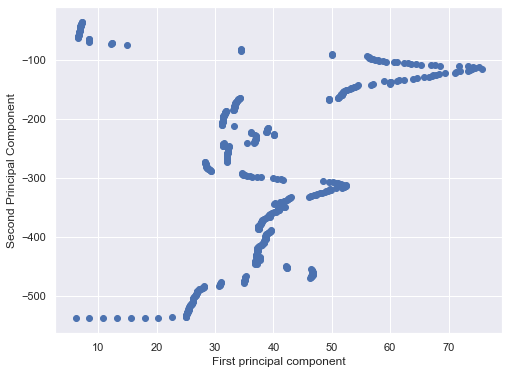

In [11]:
plt.figure(figsize=(8,6))
plt.scatter(countryData_transformed[:,0],countryData_transformed[:,1])
plt.xlabel('First principal component')
plt.ylabel('Second Principal Component')


C:\Users\thijs\AppData\Local\Temp\ipykernel_18108\2537315604.py:27: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(points, ax=axes.ravel().tolist())


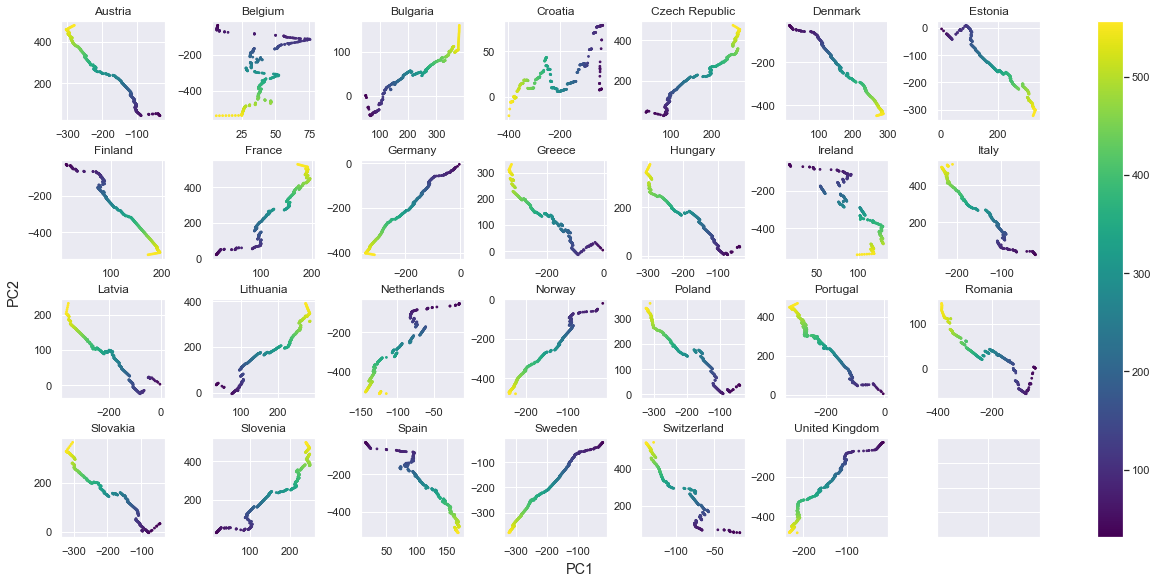

In [12]:

# plt.figure(figsize = (30,40))
fig, axes = plt.subplots(nrows=4, ncols=7, figsize = (16,8), constrained_layout=True)
for i, country in enumerate(np.unique(data["country"])):
    # print(country)
    countryData = data.loc[data['country'] == country]
    countryData = countryData.drop(['country', 'date', 'plurality'],axis=1).dropna()
    
    countryData_normalised = pd.DataFrame()
    for col in countryData.columns:
        countryData_normalised[col] = normalise_z_score(countryData[col].astype(float))

    pca = PCA(n_components = 2)
    pca.fit(countryData_normalised)
    countryData_transformed = pca.transform(countryData)
    
    # plt.subplot(5,6,i)
    # plt.figure(figsize=(8,6))
    ax = axes.flat[i]
    coloring = np.array(countryData['runday']).reshape(countryData['runday'].size,1)
    countryData_transformed = np.append(countryData_transformed, coloring, axis=1)
    points = ax.scatter(countryData_transformed[:,0], countryData_transformed[:,1], s = 3, c=coloring, cmap='viridis')
    # fg = sns.FacetGrid(data=countryData_transformed, hue='Gender', hue_order=_genders)
    ax.title.set_text(country)
fig.supxlabel('PC1')
fig.supylabel('PC2')
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.colorbar(points, ax=axes.ravel().tolist())
# plt.savefig('figures/combinedPCA.jpg', bbox_inches='tight')

In [13]:
data.head()
data_normalised = pd.DataFrame()
for col in data.columns:
    if col in data.drop(['country', 'date', 'plurality'],axis=1):
        data_normalised[col] = normalise_z_score(data[col])
    # else:
    #     data_normalised[col] = data[col]
        
data_normalised

,id,runday,country,date,new_deaths_smoothed_per_million,stringency_index,median_age,gdp_per_capita,tour_inc_gdp,civilliberties,trustp,icu_bed,plurality,oppfrac,govfrac,checks
395,-1.665946,-1.662869,Austria,25-2-2020,-0.696626,-2.513885,0.564731,0.669276,0.993948,0.453505,0.069498,1.619517,0,0.166552,-0.051855,0.204772
412,-1.665946,-1.656106,Austria,26-2-2020,-0.696626,-2.513885,0.564731,0.669276,0.993948,0.453505,0.069498,1.619517,0,0.166552,-0.051855,0.204772
429,-1.665946,-1.649344,Austria,27-2-2020,-0.696626,-2.513885,0.564731,0.669276,0.993948,0.453505,0.069498,1.619517,0,0.166552,-0.051855,0.204772
446,-1.665946,-1.642581,Austria,28-2-2020,-0.696626,-2.513885,0.564731,0.669276,0.993948,0.453505,0.069498,1.619517,0,0.166552,-0.051855,0.204772
463,-1.665946,-1.635818,Austria,29-2-2020,-0.696626,-2.513885,0.564731,0.669276,0.993948,0.453505,0.069498,1.619517,0,0.166552,-0.051855,0.204772
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12337,1.675957,1.698253,Sweden,6-7-2021,-0.674486,-0.323312,-1.094404,0.792166,0.003420,1.400232,1.433063,-0.884112,0,1.055316,-0.643515,-0.322747
12355,1.675957,1.705016,Sweden,7-7-2021,-0.665093,-0.323312,-1.094404,0.792166,0.003420,1.400232,1.433063,-0.884112,0,1.055316,-0.643515,-0.322747
12373,1.675957,1.711778,Sweden,8-7-2021,-0.658607,-0.323312,-1.094404,0.792166,0.003420,1.400232,1.433063,-0.884112,0,1.055316,-0.643515,-0.322747
12391,1.675957,1.718541,Sweden,9-7-2021,-0.658607,-0.323312,-1.094404,0.792166,0.003420,1.400232,1.433063,-0.884112,0,1.055316,-0.643515,-0.322747


In [14]:
data.isnull().values.any()
print(data.isna().sum()) 

id                                 0
runday                             0
country                            0
date                               0
new_deaths_smoothed_per_million    0
stringency_index                   0
median_age                         0
gdp_per_capita                     0
tour_inc_gdp                       0
civilliberties                     0
trustp                             0
icu_bed                            0
plurality                          0
oppfrac                            0
govfrac                            0
checks                             0
dtype: int64


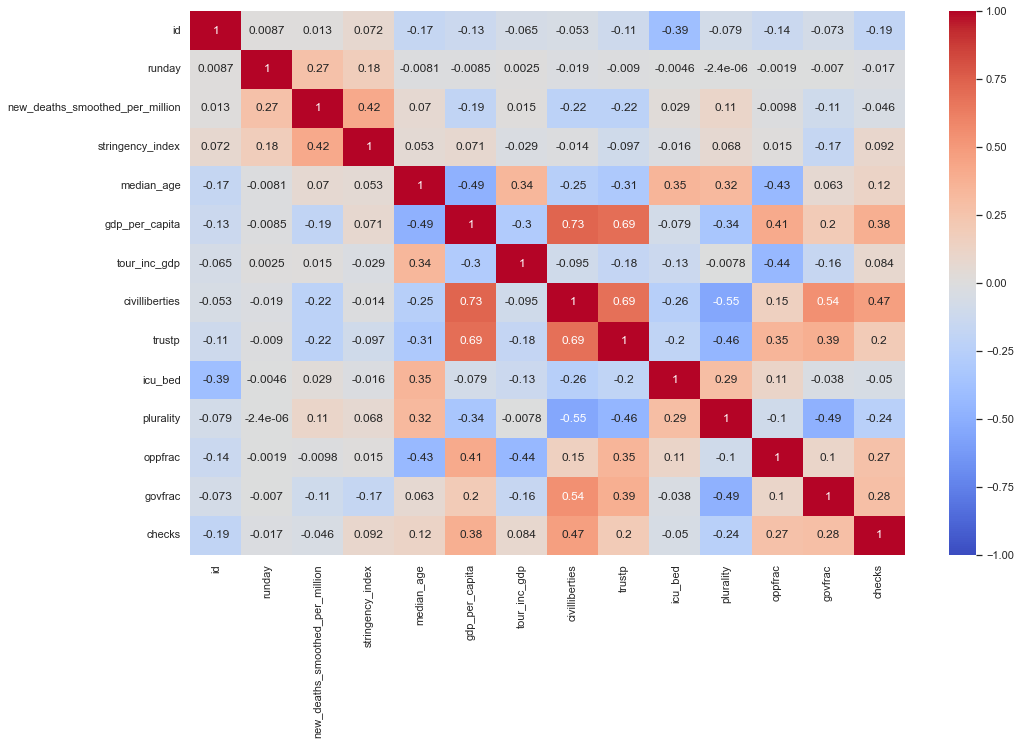

In [15]:
sns.set(rc = {'figure.figsize':(16, 10)})
dataplot = sns.heatmap(data.corr(), cmap="coolwarm", annot=True, vmin=-1, vmax=1)
plt.savefig('figures/correlations.jpg', bbox_inches='tight')

Linear regression to predict deaths per day per million

In [16]:

X = data_normalised.drop(['country', 'date', 'plurality', 'new_deaths_smoothed_per_million'],axis=1)
y = data_normalised['new_deaths_smoothed_per_million']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, shuffle=True, random_state=randomState)


model = LinearRegression().fit(X_train, y_train)
score = model.score(X_test, y_test)
score2 = mean_squared_error(model.predict(X_test), y_test)
display(score)


# plt.figure()
# plt.scatter(model.predict(X_test), y_test, alpha = 0.4)
# plt.xlabel('prections')
# plt.ylabel('data')
# display(model.())

0.2650886511075208

In [17]:
#define cross-validation method to evaluate model
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=randomState)

#define model
lassoModel = LassoCV(alphas=np.arange(0.001, 1, 0.01), cv=cv, n_jobs=-1, random_state=randomState)

#fit model
lassoModel.fit(X_train, y_train)

lassoScore = lassoModel.score(X_test, y_test)
lassoScore2 = mean_squared_error(lassoModel.predict(X_test), y_test)
print("alpha: ", lassoModel.alpha_, " score: ", lassoScore)

# plt.scatter(lassoModel.predict(X_test), y_test, alpha = 0.4)
# plt.xlabel('prections')
# plt.ylabel('data')

alpha:  0.001  score:  0.2649840980185011


In [18]:
#define cross-validation method to evaluate model
# cv = RepeatedKFold(n_splits=12, n_repeats=3, random_state=1)

#define model
ridgeModel = RidgeCV(alphas=np.arange(0.01, 1, 0.01), cv=cv)

#fit model
ridgeModel.fit(X_train, y_train)

ridgeScore = ridgeModel.score(X_test, y_test)
ridgeScore2 = mean_squared_error(ridgeModel.predict(X_test), y_test)
#display lambda that produced the lowest test MSE
print("alpha: ", ridgeModel.alpha_, " score: ", ridgeScore)

# plt.scatter(ridgeModel.predict(X_test), y_test, alpha = 0.4)
# plt.xlabel('prections')
# plt.ylabel('data')

alpha:  0.99  score:  0.26508908512739604


In [19]:
SVRModel = SVR(kernel='rbf')
SVRModel.fit(X_train,y_train)

SVRScore = SVRModel.score(X_test, y_test)
SVRScore2 = mean_squared_error(SVRModel.predict(X_test), y_test)
#display lambda that produced the lowest test MSE
print("score: ", SVRScore, SVRScore2)

# plt.scatter(SVRModel.predict(X_test), y_test, alpha = 0.4)
# plt.xlabel('prections')
# plt.ylabel('data')

score:  0.6597453630507383 0.3519964839781808


In [20]:
 # create regressor object
treeModel = RandomForestRegressor(n_estimators = 100, random_state = randomState)
  
# fit the regressor with x and y data
treeModel.fit(X_train, y_train) 

treeScore = treeModel.score(X_test, y_test)
treeScore2 = mean_squared_error(treeModel.predict(X_test), y_test)
#display lambda that produced the lowest test MSE
print("score: ", treeScore, treeScore2)




score:  0.9931586399839586 0.007077448504058354


In [21]:
 # create regressor object
xgbModel = XGBRegressor(n_estimators = 100, random_state = randomState)
  
# fit the regressor with x and y data
xgbModel.fit(X_train, y_train) 

xgbScore = xgbModel.score(X_test, y_test)
xgbScore2 = mean_squared_error(xgbModel.predict(X_test), y_test)
#display lambda that produced the lowest test MSE
print("score: ", xgbScore, xgbScore2)


C:\Users\thijs\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


score:  0.9871618564833804 0.013281175002271118


In [22]:
coefficients = pd.DataFrame(np.stack((model.coef_, lassoModel.coef_, ridgeModel.coef_), axis = 0).T, columns=['linear', 'lasso', 'ridge'], index=X.columns)
scores = [score, lassoScore, ridgeScore, SVRScore, treeScore]
scores2 = [score2, lassoScore2, ridgeScore2, SVRScore2, treeScore2]

scoreDF = pd.DataFrame(np.stack([scores,scores2]).T, index=['linear', 'lasso', 'ridge', 'svr', 'rf'], columns = ["scores",'MSE'])
display(coefficients, scoreDF)

,linear,lasso,ridge
id,-0.053363,-0.051452,-0.053351
runday,0.191351,0.190682,0.191343
stringency_index,0.408771,0.407238,0.408719
median_age,-0.086466,-0.083208,-0.086403
gdp_per_capita,-0.174412,-0.172923,-0.174346
tour_inc_gdp,0.000884,0.000000,0.000883
civilliberties,-0.136822,-0.133358,-0.136788
trustp,-0.049768,-0.049275,-0.049811
icu_bed,-0.004856,-0.003427,-0.004873
oppfrac,0.033786,0.033526,0.033810


,scores,MSE
linear,0.265089,0.760272
lasso,0.264984,0.760381
ridge,0.265089,0.760272
svr,0.659745,0.351996
rf,0.993159,0.007077


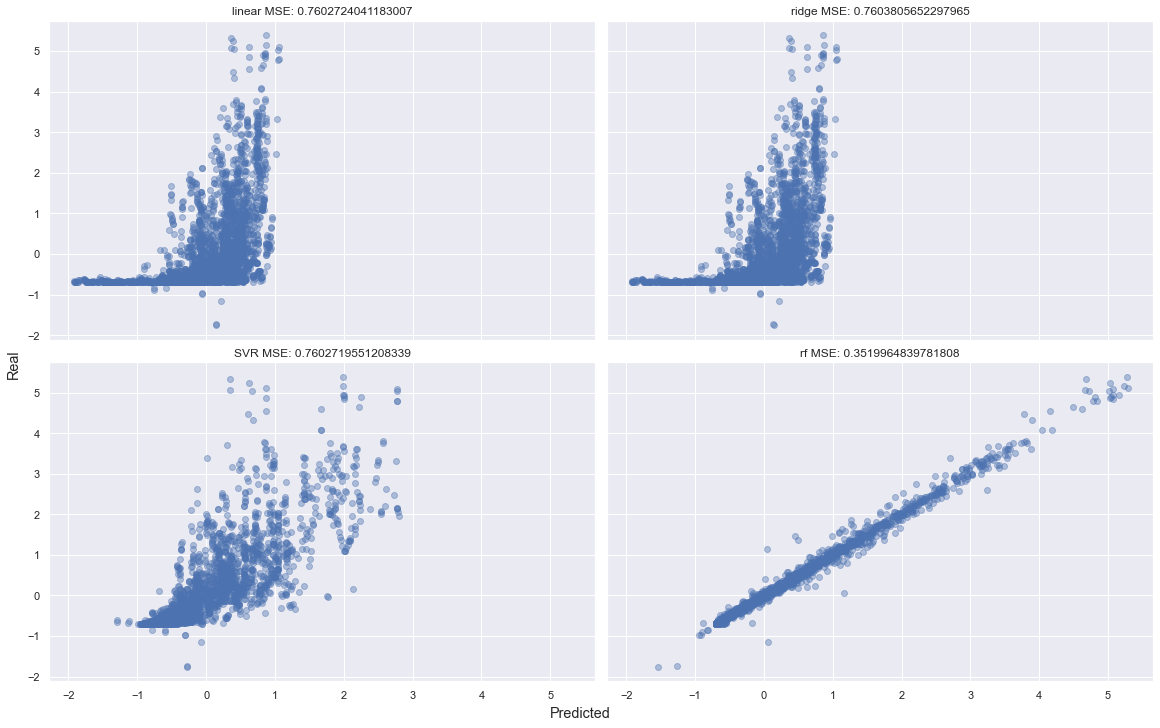

In [23]:
models = [model, ridgeModel, SVRModel, treeModel]
modelNames = ['linear', 'ridge', 'SVR', 'rf']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize = (16,10),constrained_layout=True,sharex=True, sharey=True)
for i, regModel in enumerate(models):
    ax = axes.flat[i]
    ax.scatter(regModel.predict(X_test), y_test, alpha = 0.4, cmap='viridis')
    ax.title.set_text(modelNames[i] + ' MSE: ' + str(scores2[i]))
    # plt.xlabel('prections')
    # plt.ylabel('data')
fig.supxlabel('Predicted')
fig.supylabel('Real')
plt.savefig('figures/realVsPredicted.jpg', bbox_inches='tight')